In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36337")
client

<Client: 'tcp://127.0.0.1:36337' processes=4 threads=16, memory=251.68 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import sys
from xgcm.grid import Grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/nexsan/people/abozec/BB86/'
nexs = '/nexsan/people/tuchida/'

In [4]:
pdir = op.join(nexs,'BB86_PACKAGE/PYTHON/')
sys.path.insert(0, pdir)
sys.path

['/nexsan/people/tuchida/BB86_PACKAGE/PYTHON/',
 '/home/tuchida/Notebooks/SW_Alex/04km',
 '/home/tuchida/.conda/envs/py310/lib/python310.zip',
 '/home/tuchida/.conda/envs/py310/lib/python3.10',
 '/home/tuchida/.conda/envs/py310/lib/python3.10/lib-dynload',
 '',
 '/home/tuchida/.conda/envs/py310/lib/python3.10/site-packages']

In [5]:
from hycom.info import read_field_names, read_field_grid_names
from hycom.io import read_hycom_fields, read_hycom_grid, sub_var2

In [6]:
## size of the domain
idm = 501; jdm = 501  ## size of the domain
kdm = 2                ##  number of layer in bb86
dp0 = 1000.             ## thickness of the first layer (m)
tdm = 1800             ## 12 month climatology
# tplot1 = 1800 ; tplot2 = 1800 ## time-stamp to plot (starts from 1)

normeref_hyc=0.05      ## vector norm of HYCOM-BB86 (in m/s)
onevectout = 2         ## plot one vector out of 'onevectorout'
min_dp = -450.;  max_dp = 450. ## layer thickness anomaly in m (min and max)

## constants
rho0 = 1000.    ## reference density
g = 9.806      ## gravity
oneta = 1.
montg_c = 0.
svref=1./rho0

In [7]:
##  READ the HYCOM files
expt = 31.3
dir10 = op.join(ddir,'expt_%4s/DAILY/' % expt)
dir10

'/nexsan/people/abozec/BB86/expt_31.3/DAILY/'

In [8]:
res = 4e3
# ## Read grid
# filet = '../regional.grid.a'
# grid_data = op.join(dir10,filet)
# fieldg = ['plon','plat']
# grid_field = read_hycom_grid(grid_data, fieldg)

# rame = op.join(dir10,'restart_00200101.a')
rame = op.join(dir10,'restart_out.a')
psikk = xr.DataArray(sub_var2(rame, idm, jdm, 31), dims=['YC','XC'],
                     coords={'YC':np.arange(res/2,jdm*res,res),
                             'XC':np.arange(res/2,idm*res,res)}
                    )
thkk = xr.DataArray(sub_var2(rame, idm, jdm, 32), dims=['YC','XC'],
                    coords={'YC':np.arange(res/2,jdm*res,res),
                            'XC':np.arange(res/2,idm*res,res)}
                   )

In [9]:
year = 16; day = 1
file1 = 'archm.%04d_%03d_12.a' % (year,day)
file_data = op.join(dir10, file1)
print(file_data)

# get metadata of .[ab]
# Printing the fields available in the file
print(F"The fields available are: {read_field_names(file_data)}")

/nexsan/people/abozec/BB86/expt_31.3/DAILY/archm.0016_001_12.a
The fields available are: ['montg1', 'srfhgt', 'surflx', 'salflx', 'bl_dpth', 'mix_dpth', 'tmix', 'smix', 'thmix', 'umix', 'vmix', 'kemix', 'u_btrop', 'v_btrop', 'kebtrop', 'u-vel.', 'v-vel.', 'k.e.', 'thknss', 'temp', 'salin', 'density']


In [33]:
## get layer thickness
fields = ['thknss']; layers = np.arange(kdm)
hycom_field= read_hycom_fields(file_data, fields, layers)
dp = xr.DataArray(hycom_field[fields[0]], dims=['layer','YC','XC'],
                  coords={'layer':np.array([500.,3000.]),
                          'YC':np.arange(res/2,jdm*res,res),
                          'XC':np.arange(res/2,idm*res,res)}
                 )
dphyc = dp/(rho0*g) ## convert from pressure to m
dphyc1 = xr.concat([xr.concat([dphyc.isel(layer=0)*.5,dphyc.mean('layer')
                              ], 'layer1'), dphyc.isel(layer=1)*.5
                   ], 'layer1')

## get density
fields = ['density']; layers = np.arange(kdm)
hycom_field= read_hycom_fields(file_data, fields, layers)
thstar = xr.DataArray(hycom_field[fields[0]][:,1,1], dims=['layer'],
                      coords={'layer':np.array([500.,3000.])}
                     )

## get barotropic pressure
fields = ['montg1', 'srfhgt']; layers = [0]
hycom_field = read_hycom_fields(file_data, fields, layers)
montg1 = xr.DataArray(hycom_field[fields[0]][0], dims=['YC','XC'],
                      coords={'YC':np.arange(res/2,jdm*res,res),
                              'XC':np.arange(res/2,idm*res,res)}
                     )
srfhgt = xr.DataArray(hycom_field[fields[1]][0], dims=['YC','XC'],
                      coords={'YC':np.arange(res/2,jdm*res,res),
                              'XC':np.arange(res/2,idm*res,res)}
                     )
pbavg = (srfhgt - montg1) * rho0

montg = xr.ones_like(dp) * np.nan
p = xr.concat([xr.zeros_like(montg1), 
               xr.DataArray(dp.cumsum('layer').data, 
                            dims=['layer1','YC','XC'])
              ], 'layer1')
## m_prime in lowest layer:
montg[dict(layer=-1)] = (psikk+montg_c+ 
                         ( p.isel(layer1=-1)*(thkk-thstar.isel(layer=-1)) 
                          -pbavg*thstar.isel(layer=-1) 
                         )*svref**2
                        )
## m_prime in remaining layers:
for k in range(kdm-2,1):
    montg[dict(layer=k)] = (montg.isel(layer=k+1)+p.isel(layer1=k+1)*oneta 
                            *(thstar.isel(layer=k+1)-thstar.isel(layer=k))
                            *svref**2
                           )
    print(k)

Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 201, lat: 201
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 201, lat: 201
	Reading layers [0, 1] for field density. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 201, lat: 201
	Reading layers [0] for field montg1. Total layers: 1
	Reading layers [0] for field srfhgt. Total layers: 1
0


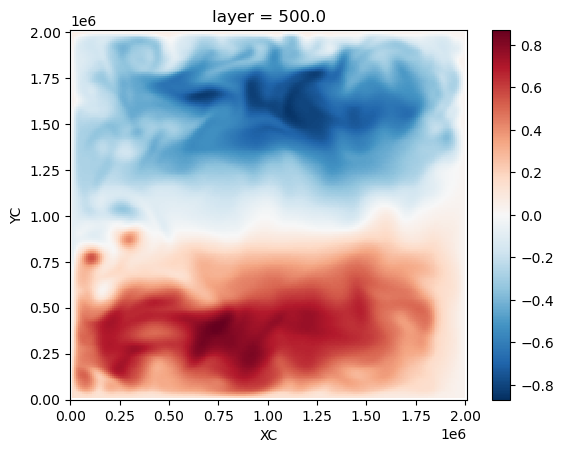

In [34]:
montg.isel(layer=0).plot()

In [17]:
xchunk = 167
ychunk = 167
years = np.arange(16,21)
days = np.arange(361)

for yy in years:
    nd = 0
    for dd in days:

        file2 = 'archm.%04d_%03d_12.a' % (yy,dd)
        
        if op.exists(op.join(dir10, file2)):
            file_data = op.join(dir10, file2)
            # get barotropic velocities
            fields = ['u_btrop','v_btrop']; layers = [0]
            hycom_field = read_hycom_fields(file_data, fields, layers)
            ubaro = xr.DataArray(hycom_field[fields[0]][0], dims=['YC','XG'],
                                 coords={'YC':np.arange(res/2,jdm*res,res),
                                         'XG':np.arange(0,idm*res,res)}
                                )
            vbaro = xr.DataArray(hycom_field[fields[1]][0], dims=['YG','XC'],
                                 coords={'YG':np.arange(0,jdm*res,res),
                                         'XC':np.arange(res/2,idm*res,res)}
                                )
            
            # get total velocities
            ## Note that u-vel and v-vel are total velocities in time-average file (archm)
            ## Note that u-vel and v-vel are baroclinic velocities in instantaneous file (archv)
            fields = ['u-vel.','v-vel.']; layers = np.arange(kdm)
            hycom_field = read_hycom_fields(file_data, fields, layers)
            utot = xr.DataArray(hycom_field[fields[0]], dims=['layer','YC','XG'],
                                coords={'YC':np.arange(res/2,jdm*res,res),
                                        'XG':np.arange(0,idm*res,res)}
                               )
            vtot = xr.DataArray(hycom_field[fields[1]], dims=['layer','YG','XC'],
                                coords={'YG':np.arange(0,jdm*res,res),
                                        'XC':np.arange(res/2,idm*res,res)}
                               )
            
            # ##Get baroclinic velocities
            # ubac = utot-ubaro
            # vbac = vtot-vbaro
            
            ## get layer thickness
            fields = ['thknss']; layers = np.arange(kdm)
            hycom_field= read_hycom_fields(file_data, fields, layers)
            dp = xr.DataArray(hycom_field[fields[0]], dims=['layer','YC','XC'],
                              coords={'layer':np.array([500.,3000.]),
                                      'YC':np.arange(res/2,jdm*res,res),
                                      'XC':np.arange(res/2,idm*res,res)}
                             )
            dphyc = dp/(rho0*g) ## convert from pressure to m
            dphyc1 = xr.concat([xr.concat([dphyc.isel(layer=0)*.5,dphyc.mean('layer')
                                          ], 'layer1'), dphyc.isel(layer=1)*.5
                               ], 'layer1')
            
            ## get density
            fields = ['density']; layers = np.arange(kdm)
            hycom_field= read_hycom_fields(file_data, fields, layers)
            thstar = xr.DataArray(hycom_field[fields[0]][:,1,1], dims=['layer'],
                                  coords={'layer':np.array([500.,3000.])}
                                 )
            
            ## get barotropic pressure
            fields = ['montg1', 'srfhgt']; layers = [0]
            hycom_field = read_hycom_fields(file_data, fields, layers)
            montg1 = xr.DataArray(hycom_field[fields[0]][0], dims=['YC','XC'],
                                  coords={'YC':np.arange(res/2,jdm*res,res),
                                          'XC':np.arange(res/2,idm*res,res)}
                                 )
            srfhgt = xr.DataArray(hycom_field[fields[1]][0], dims=['YC','XC'],
                                  coords={'YC':np.arange(res/2,jdm*res,res),
                                          'XC':np.arange(res/2,idm*res,res)}
                                 )
            pbavg = (srfhgt - montg1) * rho0
            
            montg = xr.ones_like(dp) * np.nan
            p = xr.concat([xr.zeros_like(montg1), 
                           xr.DataArray(dp.cumsum('layer').data, 
                                        dims=['layer1','YC','XC'])
                          ], 'layer1')
            ## m_prime in lowest layer:
            montg[dict(layer=-1)] = (psikk+montg_c+ 
                                     ( p.isel(layer1=-1)*(thkk-thstar.isel(layer=-1)) 
                                      -pbavg*thstar.isel(layer=-1) 
                                     )*svref**2
                                    )
            ## m_prime in remaining layers:
            for k in range(kdm-2,1):
                montg[dict(layer=k)] = (montg.isel(layer=k+1)+p.isel(layer1=k+1)*oneta 
                                        *(thstar.isel(layer=k+1)-thstar.isel(layer=k))
                                        *svref**2
                                       )

            if yy == years[0] and dd == 1:
                ds = utot.to_dataset(name='utot')
                ds['vtot'] = vtot
                # ds['ubac'] = ubac
                # ds['vbac'] = vbac
                ds['ubaro'] = ubaro
                ds['vbaro'] = vbaro
                ds['pres'] = dp
                ds['dZp1'] = dphyc
                ds['dZ'] = dphyc1
                ds['mp'] = montg
                # ds['Zp1'] = dphyc.mean('layer')
                ds.coords['layer1'] = ('layer1',np.array([0.,1000.,5000.]))
                ds = ds.chunk({'layer':1,'layer1':1,
                               'YC':ychunk,'YG':ychunk,
                               'XC':xchunk,'XG':xchunk})
            else:
                _ds = utot.to_dataset(name='utot')
                _ds['vtot'] = vtot
                # _ds['ubac'] = ubac
                # _ds['vbac'] = vbac
                _ds['ubaro'] = ubaro
                _ds['vbaro'] = vbaro
                _ds['pres'] = dp
                _ds['dZp1'] = dphyc
                _ds['dZ'] = dphyc1
                _ds['mp'] = montg
                # _ds['Zp1'] = dphyc.mean('layer')
                _ds.coords['layer1'] = ('layer1',np.array([0.,1000.,5000.]))
                _ds = _ds.chunk({'layer':1,'layer1':1,
                                 'YC':ychunk,'YG':ychunk,
                                 'XC':xchunk,'XG':xchunk})
                ds = xr.concat([ds,_ds], 'time')
                _ds.close()
            nd += 1
            
        else:
            pass
            
    if yy == years[0]:
        year = np.repeat(yy,nd)
    else:
        year = np.concatenate((year,np.repeat(yy,nd)))
    
ds.coords['year'] = ('time',year)
# ds.coords['lat'] = plat
# ds.coords['lon'] = plon
# ds

Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0] for field u_btrop. Total layers: 1
	Reading layers [0] for field v_btrop. Total layers: 1
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field u-vel.. Total layers: 2
	Reading layers [0, 1] for field v-vel.. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field density. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0] f

In [18]:
ds = ds.chunk({'time':10})
ds

<xarray.Dataset>
Dimensions:  (YC: 501, XG: 501, time: 1800, layer: 2, YG: 501, XC: 501,
              layer1: 3)
Coordinates:
  * YC       (YC) float64 2e+03 6e+03 1e+04 ... 1.994e+06 1.998e+06 2.002e+06
  * XG       (XG) float64 0.0 4e+03 8e+03 1.2e+04 ... 1.992e+06 1.996e+06 2e+06
  * YG       (YG) float64 0.0 4e+03 8e+03 1.2e+04 ... 1.992e+06 1.996e+06 2e+06
  * XC       (XC) float64 2e+03 6e+03 1e+04 ... 1.994e+06 1.998e+06 2.002e+06
  * layer    (layer) float64 500.0 3e+03
  * layer1   (layer1) float64 0.0 1e+03 5e+03
    year     (time) int64 dask.array<chunksize=(10,), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    utot     (time, layer, YC, XG) float64 dask.array<chunksize=(10, 1, 167, 167), meta=np.ndarray>
    vtot     (time, layer, YG, XC) float64 dask.array<chunksize=(10, 1, 167, 167), meta=np.ndarray>
    ubaro    (time, YC, XG) float64 dask.array<chunksize=(10, 167, 167), meta=np.ndarray>
    vbaro    (time, YG, XC) float64 dask.array<chunksize=(10, 167, 167), meta=np.ndarray>
    pres     (time, layer, YC, XC) float64 dask.array<chunksize=(10, 1, 167, 167), meta=np.ndarray>
    dZp1     (time, layer, YC, XC) float64 dask.array<chunksize=(10, 1, 167, 167), meta=np.ndarray>
    dZ       (time, layer1, YC, XC) float64 dask.array<chunksize=(10, 1, 167, 167), meta=np.ndarray>
    mp       (time, layer, YC, XC) float64 dask.array<chunksize=(10, 1, 167, 167), meta=np.ndarray>

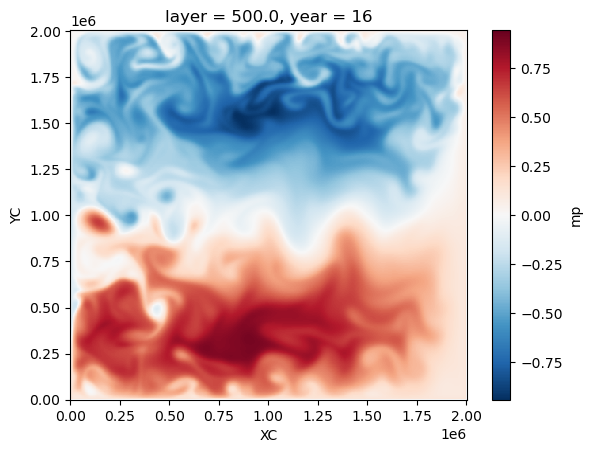

In [13]:
ds.mp.isel(time=0,layer=0).plot()

In [19]:
coords={
        "T": {"center": "time"},
        "X": {"center": "XC",    "left": "XG"},
        "Y": {"center": "YC",    "left": "YG"},
        "Z": {"center": "layer", "outer": "layer1"}
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   layer --> outer
  * outer    layer1 --> center

In [ ]:
KE = .5*(grid.interp(ds.utot**2,'X',boundary='extend')
         + grid.interp(ds.vtot**2,'Y',boundary='extend')
        )
HKE = (KE * ds.dZp1).sum('layer')
HKE

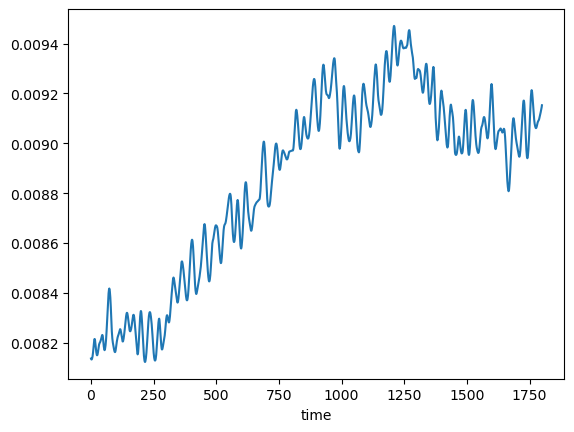

In [14]:
(HKE / 6e3).mean(['YC','XC']).plot()

In [20]:
Z = grid.cumsum(ds.dZ,'Z',boundary='extend',to='center')
Zp1 = grid.cumsum(ds.dZp1,'Z',boundary='extend',to='outer')
Zp1

<xarray.DataArray 'dZp1' (time: 1800, layer1: 3, YC: 501, XC: 501)>
dask.array<concatenate, shape=(1800, 3, 501, 501), dtype=float64, chunksize=(10, 1, 167, 167), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 2e+03 6e+03 1e+04 ... 1.994e+06 1.998e+06 2.002e+06
  * XC       (XC) float64 2e+03 6e+03 1e+04 ... 1.994e+06 1.998e+06 2.002e+06
  * layer1   (layer1) float64 0.0 1e+03 5e+03
Dimensions without coordinates: time

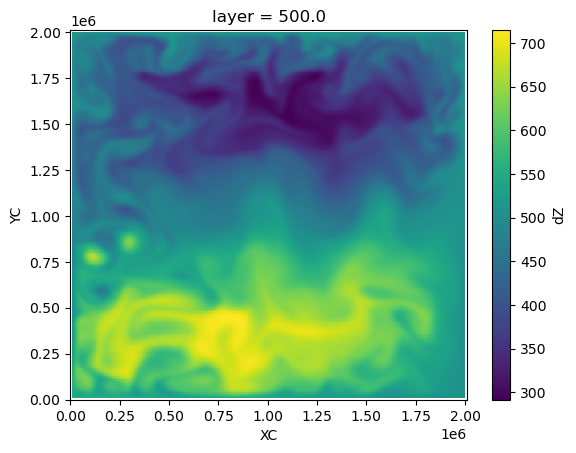

In [49]:
Z.where(Z>0.).isel(time=0,layer=0).plot()

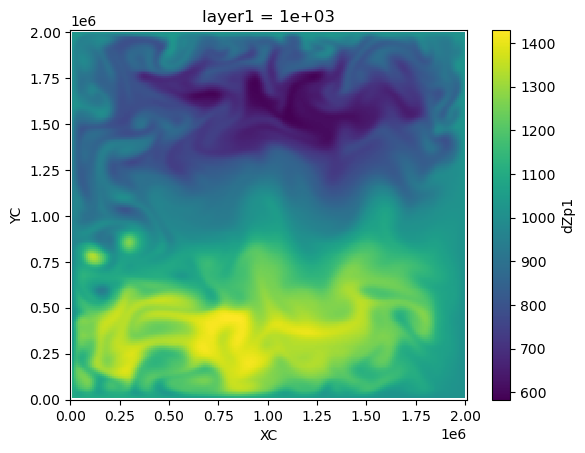

In [56]:
Zp1.where(Zp1>0.).isel(time=0,layer1=1).plot()

In [21]:
dsb = ((ds.utot*grid.interp(ds.dZp1,'X',boundary='extend')).mean('time') 
       / grid.interp(ds.dZp1,'X',boundary='extend').mean('time')
      ).to_dataset(name='uhat')
dsb['vhat'] = ((ds.vtot*grid.interp(ds.dZp1,'Y',boundary='extend')).mean('time') 
               / grid.interp(ds.dZp1,'Y',boundary='extend').mean('time')
              )
dsb['Z'] = Z.mean('time')
dsb['Zp1'] = Zp1.isel(layer1=1).mean('time')
# dsb['dZ'] = ds.dZ.mean('time')
# dsb['dZp1'] = ds.dZp1.mean('time')
dsb['montpot'] = ds.mp.mean('time')
dsb.to_zarr(op.join(nexs,'BB86/expt_%4s/DAILY/Mean/YY16-20.zarr' 
                    % (expt)), mode='w')

In [16]:
dsb = xr.open_zarr(op.join(nexs,'BB86/expt_%4s/DAILY/Mean/YY16-20.zarr' 
                           % expt)
                  )
coords={
        "X": {"center": "XC",    "left": "XG"},
        "Y": {"center": "YC",    "left": "YG"},
        "Z": {"center": "layer"}
       }
gridb = Grid(dsb, periodic=[],
            coords=coords
           )

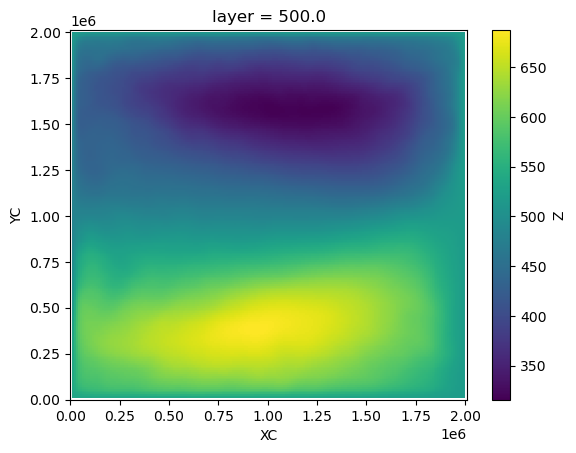

In [48]:
dsb.Z.where(dsb.Z>0.).isel(layer=0).plot()

In [17]:
MKE = .5*(gridb.interp(dsb.uhat**2,'X',boundary='extend')
         + gridb.interp(dsb.vhat**2,'Y',boundary='extend')
        )
MKE

<xarray.DataArray (layer: 2, YC: 201, XC: 201)>
dask.array<mul, shape=(2, 201, 201), dtype=float64, chunksize=(2, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 5e+03 1.5e+04 2.5e+04 ... 1.995e+06 2.005e+06
  * YC       (YC) float64 5e+03 1.5e+04 2.5e+04 ... 1.995e+06 2.005e+06
  * layer    (layer) float64 500.0 3e+03

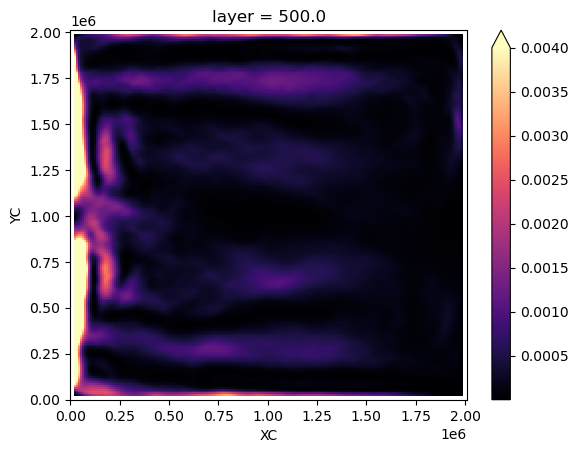

In [21]:
MKE.isel(layer=0).plot(cmap='magma', vmax=4e-3)